<div style="width: 30%; float: right; margin: 10px; margin-right: 5%;">
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d3/FHNW_Logo.svg/2560px-FHNW_Logo.svg.png" width="500" style="float: left; filter: invert(50%);"/>
</div>

<h1 style="text-align: left; margin-top: 10px; float: left; width: 60%;">
    SAN Projekt:<br> Schweizer Offshore Firmen
</h1>

<p style="clear: both; text-align: left;">
    Bearbeitet durch Florin Barbisch, Gabriel Torres Gamez und Tobias Buess im FS 2024.
</p>

Wir führen eine Voranalyse für das Bundesamt für Statistik durch, um die kürzlich aufgetretenen Leaks aus den Offshore Papers zu untersuchen. 

Diese Analyse zielt darauf ab, Umfang und Natur der Verbindungen in Schweizer Offshore-Strukturen zu ermitteln. Wir verwenden dafür Daten aus der [Offshore Leaks Database](https://offshoreleaks.icij.org/), um mögliche Muster, wichtige Personen aufzudecken, die für die Steuerbehörden oder Regulierungsorgane von Interesse sein könnten. 

Unsere Arbeit umfasst eine detaillierte Prüfung der betroffenen Entitäten. Dies wird es dem Bundesamt für Statistik ermöglichen, fundierte Entscheidungen zur weiteren Untersuchung und möglichen Massnahmen zu treffen.

## Imports und Einstellungen

In [1]:
# Python internal modules
import os

# Project modules
import utils

# External modules
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt

BACKEND = None  # use default
if "cugraph" in nx.utils.backends.backends.keys():
    import nx_cugraph as nxcg
    BACKEND = "cugraph"

print("Python Environment:")
print(f" | Python version: {os.sys.version}")
print(f" | Numpy version: {np.__version__}")
print(f" | Pandas version: {pd.__version__}")
print(f" | Matplotlib version: {matplotlib.__version__}")
print(f" | NetworkX version: {nx.__version__}")
print(f" | NetworkX backend: {BACKEND}")
print(
    f" | CuGraph version: {nxcg.__version__}"
    if BACKEND == "cugraph"
    else " | CuGraph not installed, for better performance install it like this:\n\tpip install cugraph-cu12 --extra-index-url=https://pypi.ngc.nvidia.com"
)
print()
print("Ressources:")
print(f" | CPU: {os.cpu_count()} cores")

PAPERS = "Pandora Papers"
GRAPH_PATH = f"./data/{PAPERS.lower().replace(' ', '_')}_graph.gexf"

plt.rcParams["figure.figsize"] = [10, 3]
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.size"] = 6

color_map = {
    "Entity": "#ff8080",
    "Officer": "#B0C4DE",
    "Intermediary": "tab:green",
    "Address": "#FFFF00",
    "Other": "tab:gray",
}

Python Environment:
 | Python version: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
 | Numpy version: 1.26.4
 | Pandas version: 2.2.1
 | Matplotlib version: 3.8.4
 | NetworkX version: 3.3
 | NetworkX backend: cugraph
 | CuGraph version: 24.04.00

Ressources:
 | CPU: 24 cores


## Daten laden

In [2]:
# Graph mit allen Nodes/Edges von den gewählten Papers laden
G = utils.get_graph(GRAPH_PATH, PAPERS)

# Subgraph mit allen Nodes/Edges von Connected Components welche mindestens 1 Schweizer Adresse beinhalten
G = utils.filter_graph_by_country_name(G, "Switzerland", verbose=True)

Info pre filtering:
Number of edges:  145874
Number of nodes:  108053
Number of weakly connected components:  2643

Filtering the graph after the country "Switzerland"

Info post filtering:
Number of edges:  127482
Number of nodes:  91864
Number of weakly connected components:  53


Beachte, dass hier nur Connected Components genommen wurden, welche mindesten 1 Knoten mit einer schweizerischen Adresse beinhaltet.
Die Anzahl Connected Components konnte erfolgreich verkleinert werden. Dies vereinfacht unsere Analyse.

## Welche Schweizer Officers haben die meisten Offshore Firmen? 

In [3]:
# get subgraph with all swiss officers and their entities
swiss_officers_entities_subgraph, swiss_officers, all_entities = (
    utils.get_swiss_officer_entities_subgraph(G)
)

# calculate the out-degree of the swiss officers in regard to their entities
degree = dict(swiss_officers_entities_subgraph.out_degree(swiss_officers))
degree = dict(sorted(degree.items(), key=lambda item: item[1], reverse=True))

Hier holen wir ein Subgraph, welcher alle Schweizer Officers und deren Offshore Firmen beinhaltet. Als nächstes Visualisieren wir die Anzahl Offshore Firmen pro Officer und visualisieren das Ego-Netzwerk von den Top 5 Officers.

Node: 240510503, Name: Adrian Guldener, Entity Out-Degree: 3


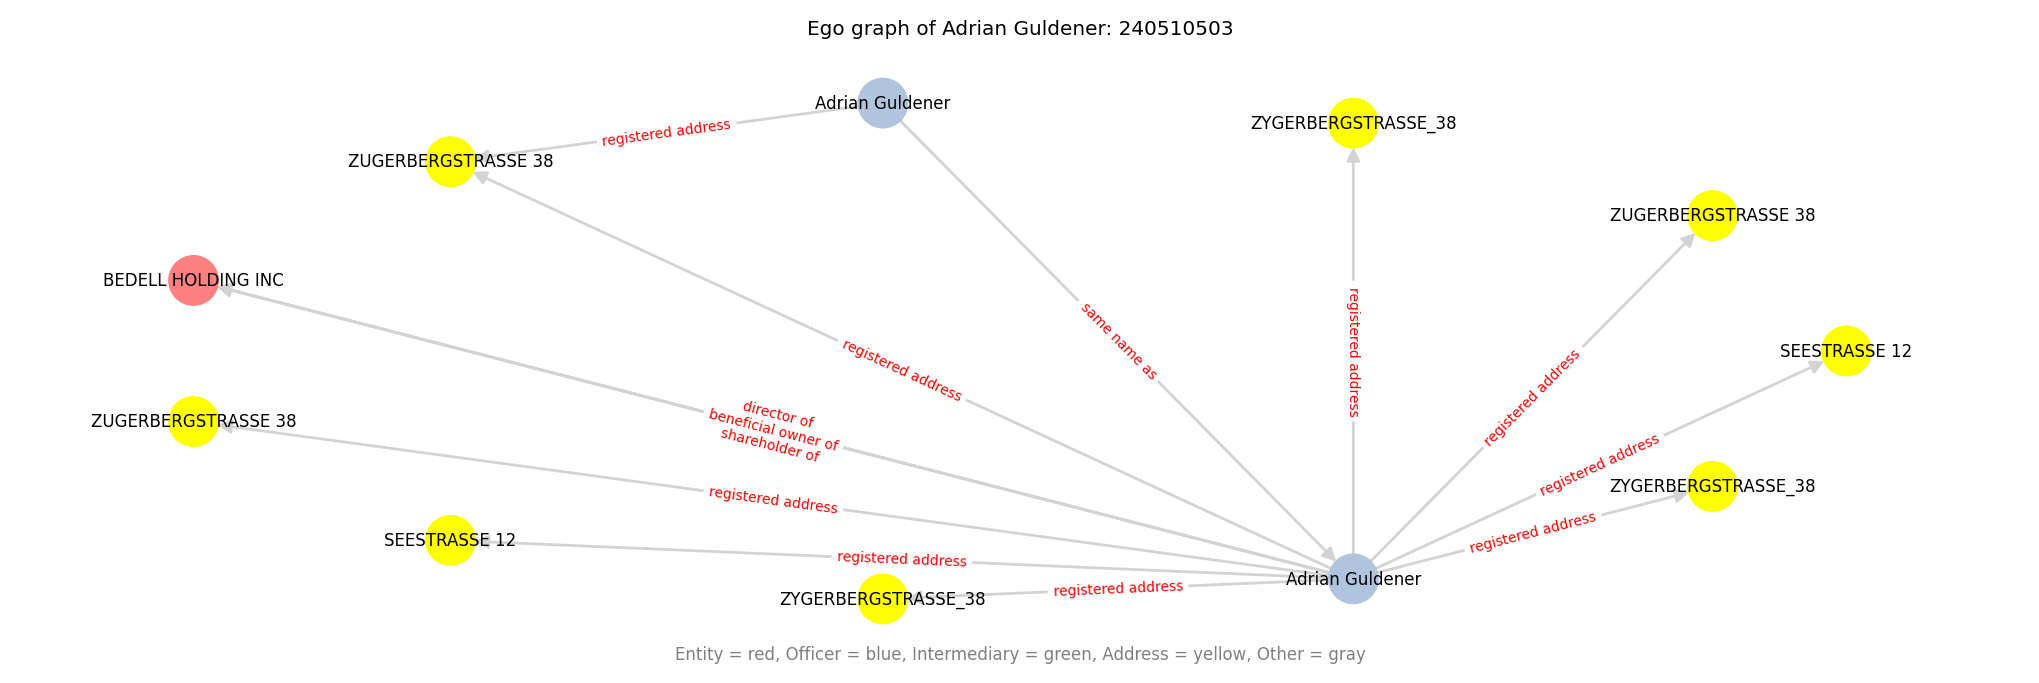

Node: 240510584, Name: Serge Vollenweider, Entity Out-Degree: 3


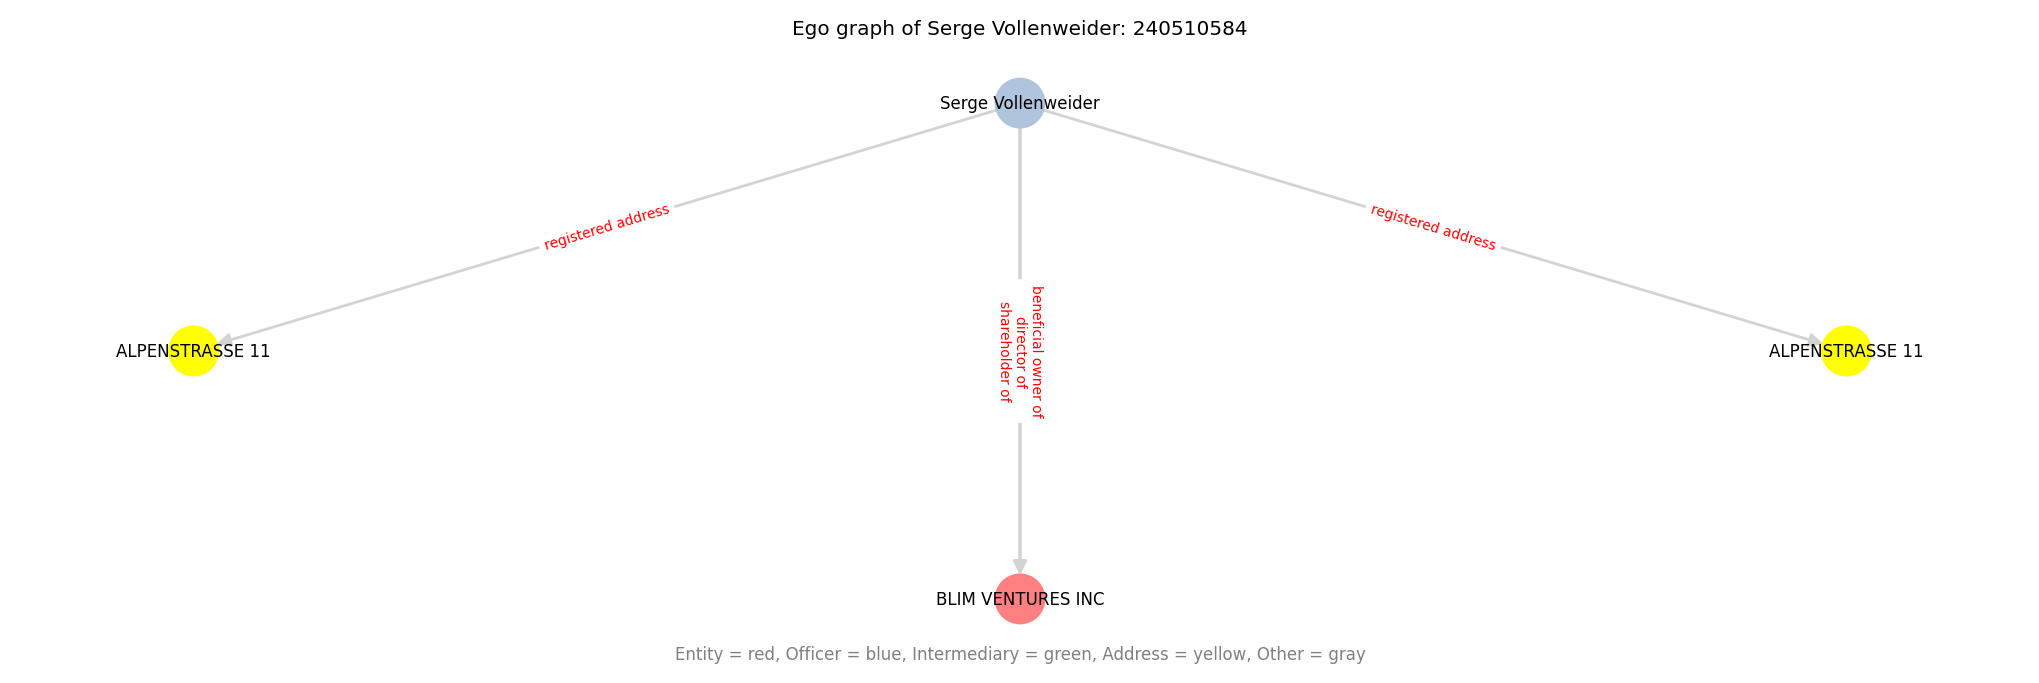

Node: 240513480, Name: Davorin Dovoda, Entity Out-Degree: 3


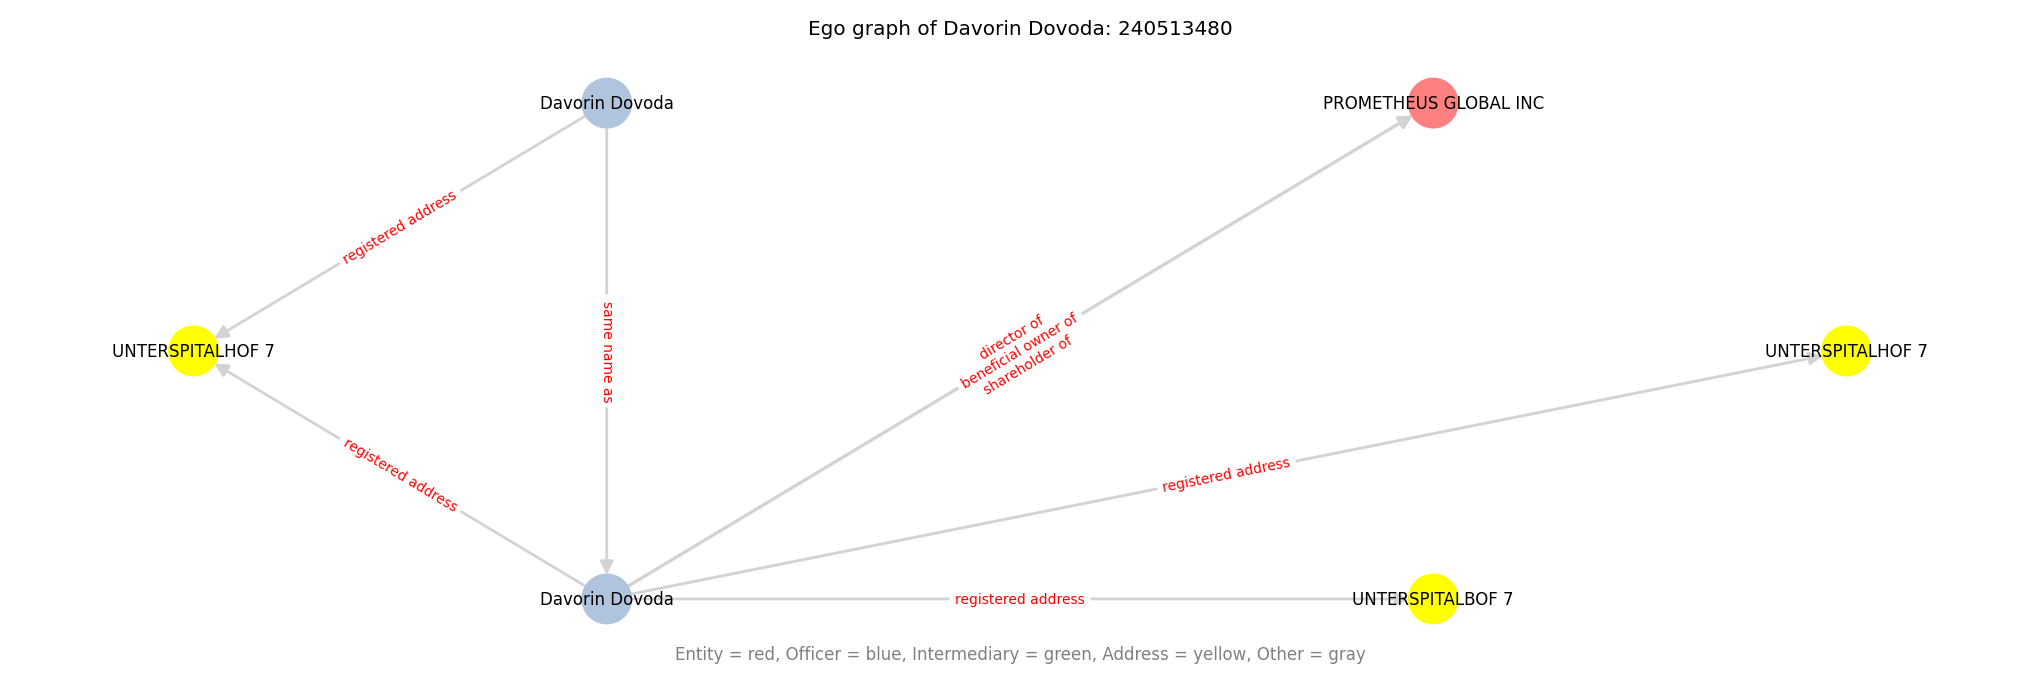

Node: 240380579, Name: GEORGE SHALCHU GEH, Entity Out-Degree: 2


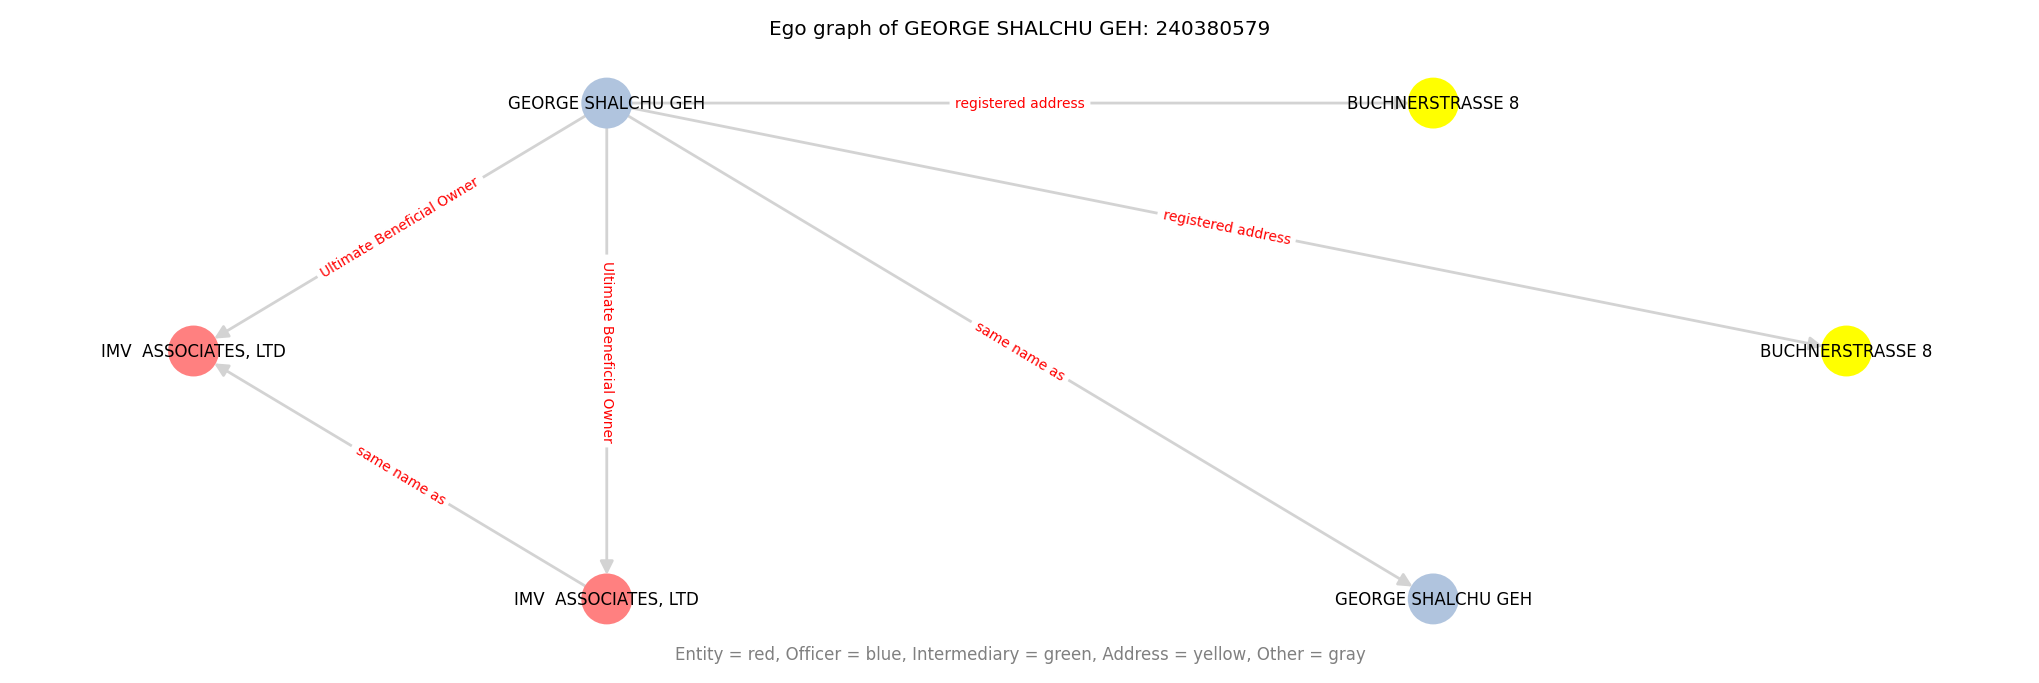

Node: 240380005, Name: SEYED MOHAMAD SADREDIN GOLSTANEH, Entity Out-Degree: 2


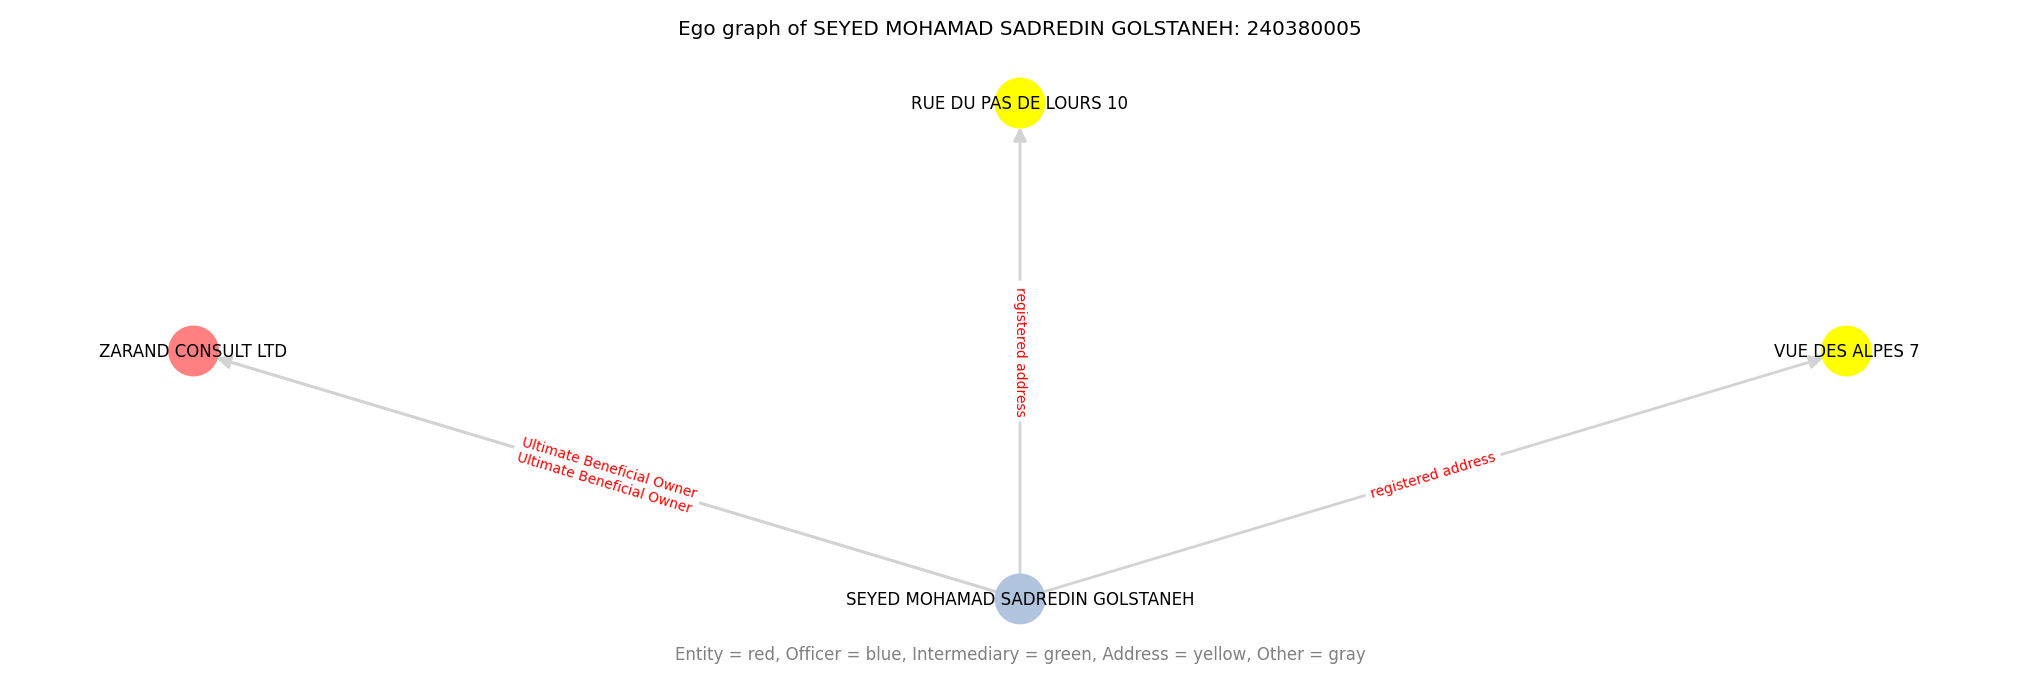

In [4]:
for node, deg in list(degree.items())[:5]:
    print(f"Node: {node}, Name: {G.nodes[node]['name']}, Entity Out-Degree: {deg}")
    utils.plot_ego_with_labels(G, node, color_map)

Beim Adrian Guldener sehen wir eigentlich nur eine benachbarte Entitäts Node, jedoch beträgt der Entity-Out-Degree 3. Dies liegt daran, dass es drei parallele Verbindungen zu dieser Node gibt, da dieser Officer sowohl Direktor, Beneficial Owner sowie Shareholder dieser Entität ist. 

Es gibt nur wenige Entity Out-Degrees für alle Schweizer Officer Nodes. Jedoch existieren anscheinend mehrere Officer und Address Nodes im Datensatz gleich zu sein. Als nächstes erweitern wir den ego_radius der Visualisierung und visualiseren nur den ersten Officer.

Node: 240510503, Name: Adrian Guldener, Entity Out-Degree: 3


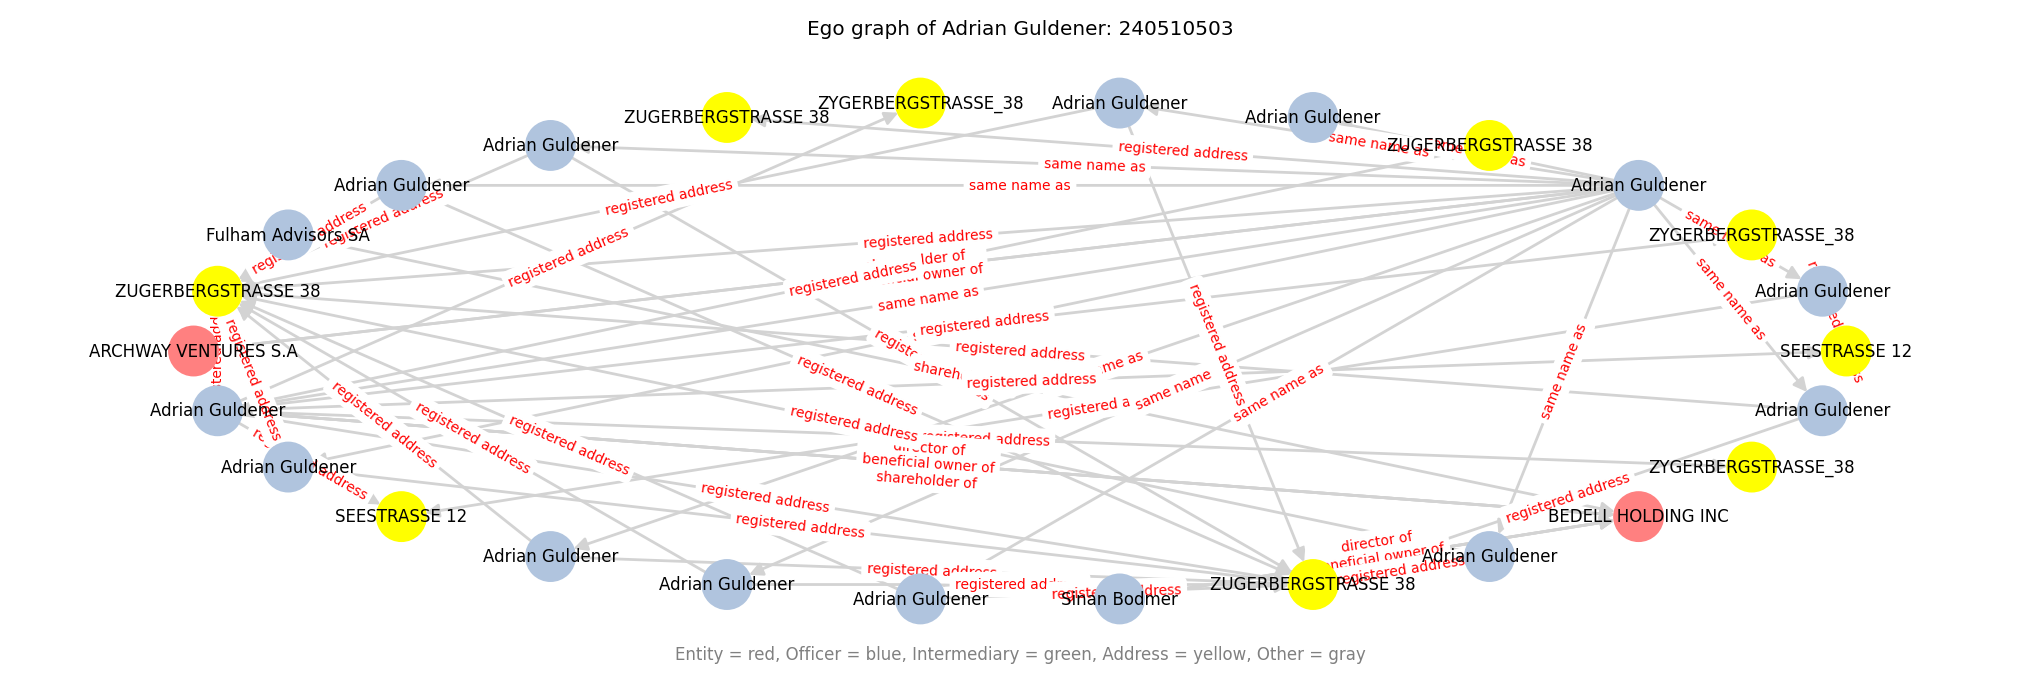

In [5]:
for node, deg in list(degree.items())[:1]:
    print(f"Node: {node}, Name: {G.nodes[node]['name']}, Entity Out-Degree: {deg}")
    utils.plot_ego_with_labels(G, node, color_map, ego_radius=2)

Das Problem scheint gross zu sein. Es gibt anscheinend sehr viele Adrian Guldener Nodes. Da es sich hier sehr wahrscheinlich um die gleiche Person handelt, vereinigen wir als nächstes alle Nodes, welche gemeinsame Attribute haben.

Da es auch einige Edges gibt, welche die gleiche Beschreibung haben, vereinigen wir auch diese zu einer Edge.

In [6]:
print(f"Number of nodes: {len(G.nodes)}")
new_G = utils.merge_duplicate_nodes(
    G, exclude_attributes=["label", "countries", "sourceID", "valid_until", "note"]
)
print(f"Number of nodes after removing duplicates: {len(new_G.nodes)}")

print(f"Number of edges: {len(G.edges)}")
new_G = utils.remove_duplicate_edges(new_G)
print(f"Number of edges after removing duplicates: {len(new_G.edges)}")

Number of nodes: 91864


Merging duplicate nodes:   0%|          | 0/74938 [00:00<?, ?it/s]

Number of nodes after removing duplicates: 74938
Number of edges: 127482


Removing duplicate edges:   0%|          | 0/110388 [00:00<?, ?it/s]

Number of edges after removing duplicates: 97122


Jetzt berechnen wir auf den gleichen Graphen wieder den Subgraph der Schweizer Officers und deren Offshore Firmen.

In [7]:
# get subgraph with all swiss officers and their entities
swiss_officers_entities_subgraph, swiss_officers, all_entities = (
    utils.get_swiss_officer_entities_subgraph(new_G)
)

# calculate the out-degree of the swiss officers in regard to their entities
degree = dict(swiss_officers_entities_subgraph.out_degree(swiss_officers))
degree = dict(sorted(degree.items(), key=lambda item: item[1], reverse=True))

Als nächstes visualisieren wir wieder das Ego-Netzwerk von den Top 5 Officers.

Node: 240045125, Name: RUSLAN GORYUKHIN, Entity Out-Degree: 28


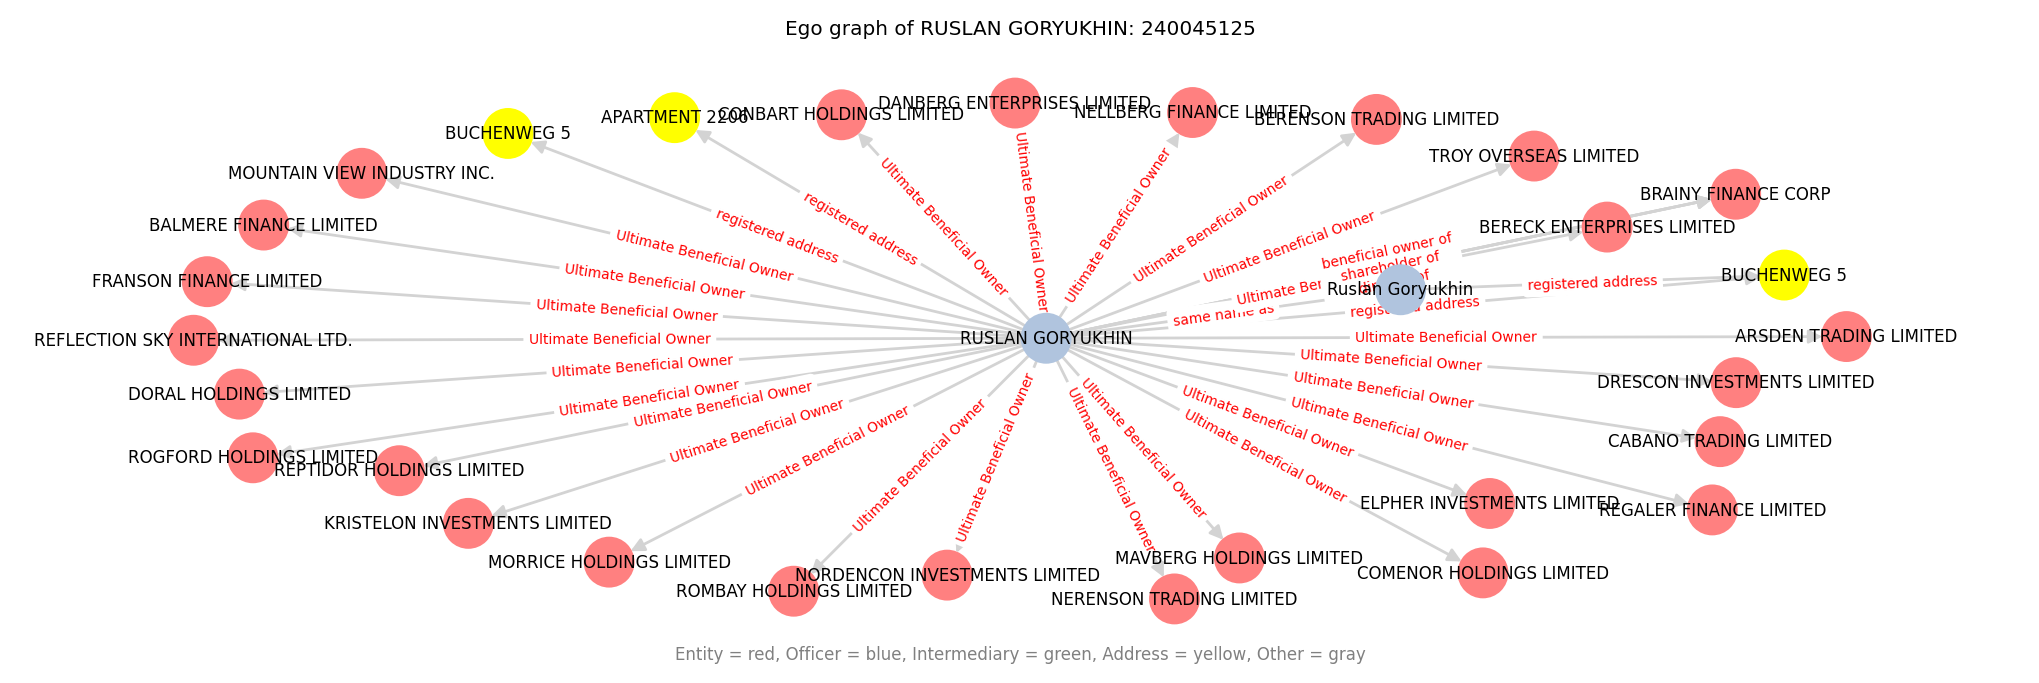

Node: 240510272, Name: Adrian Guldener, Entity Out-Degree: 27


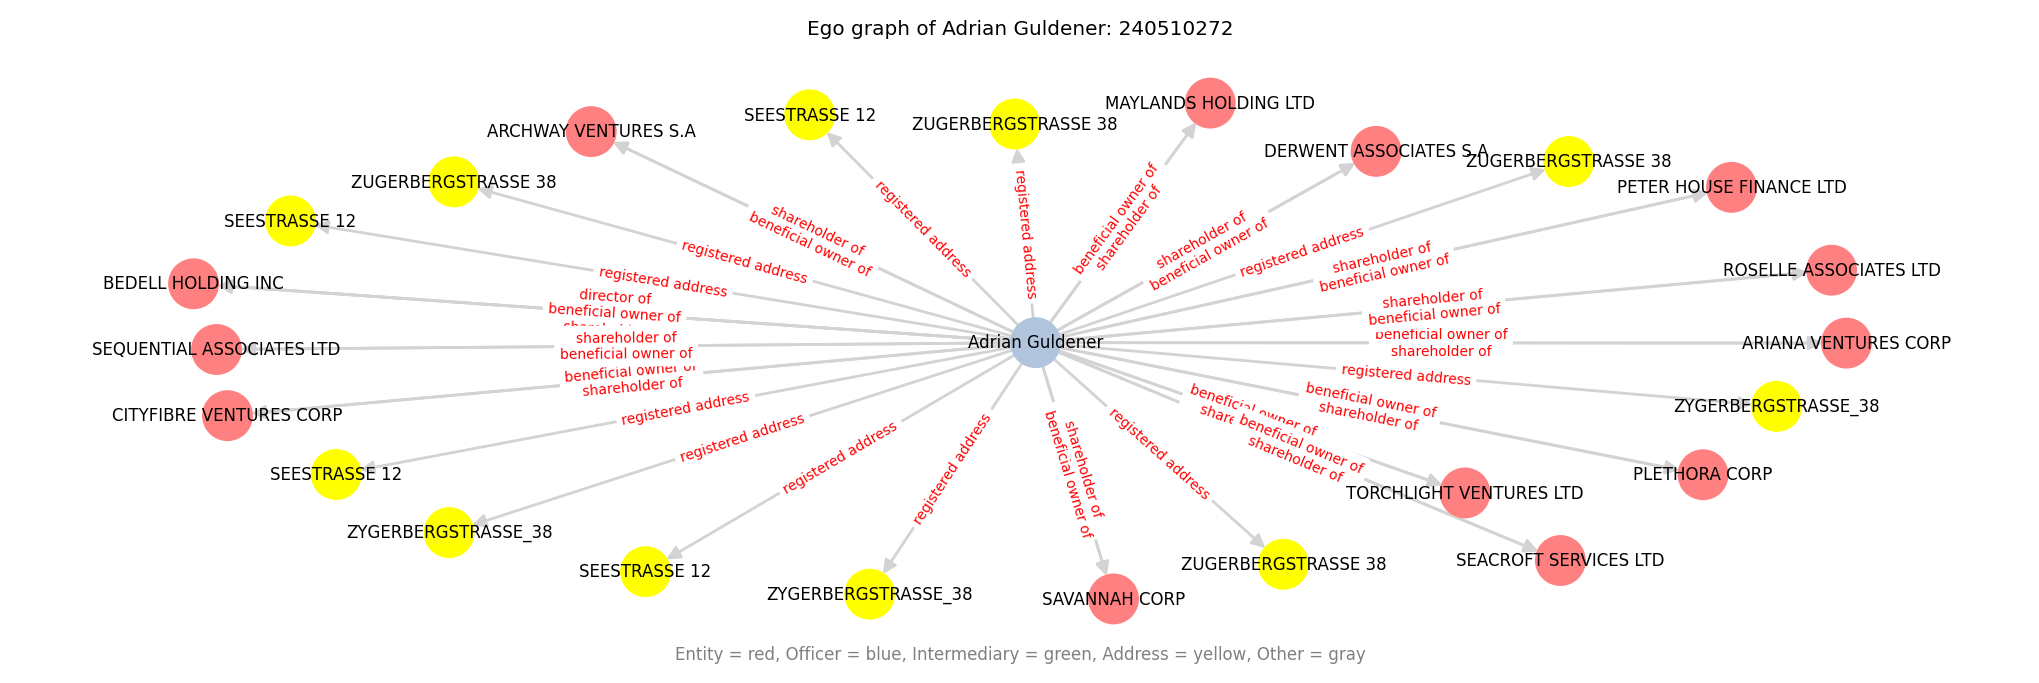

Node: 240054765, Name: UNION BANCAIRE PRIVEE UBP S.A., Entity Out-Degree: 21


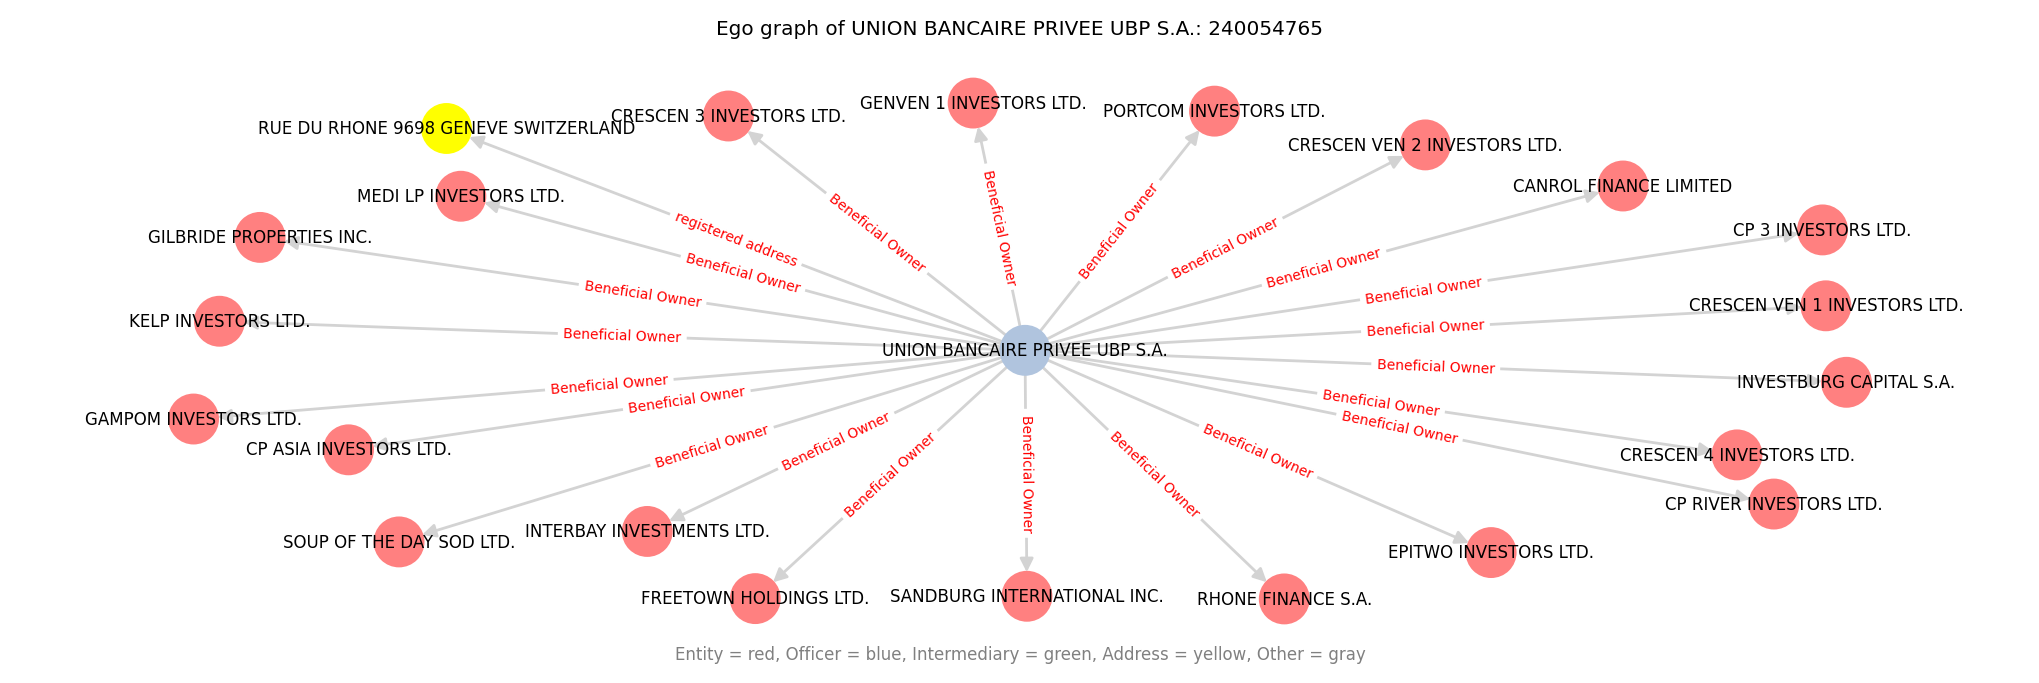

Node: 240041491, Name: VICTORIA JANE LORAINE, Entity Out-Degree: 16


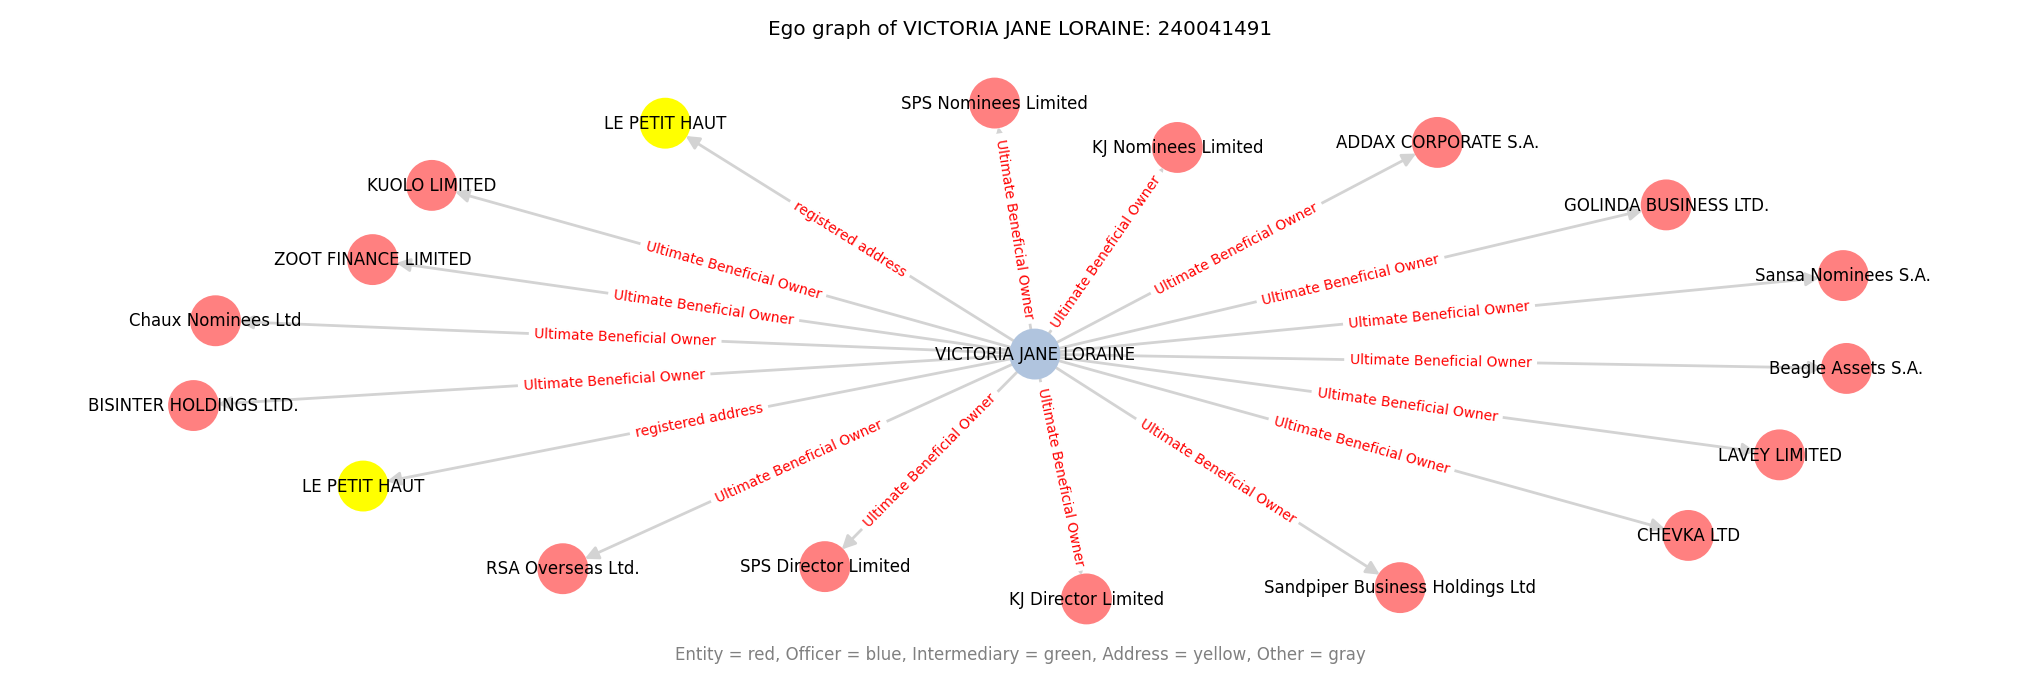

Node: 240514621, Name: Alexander Studhalter, Entity Out-Degree: 15


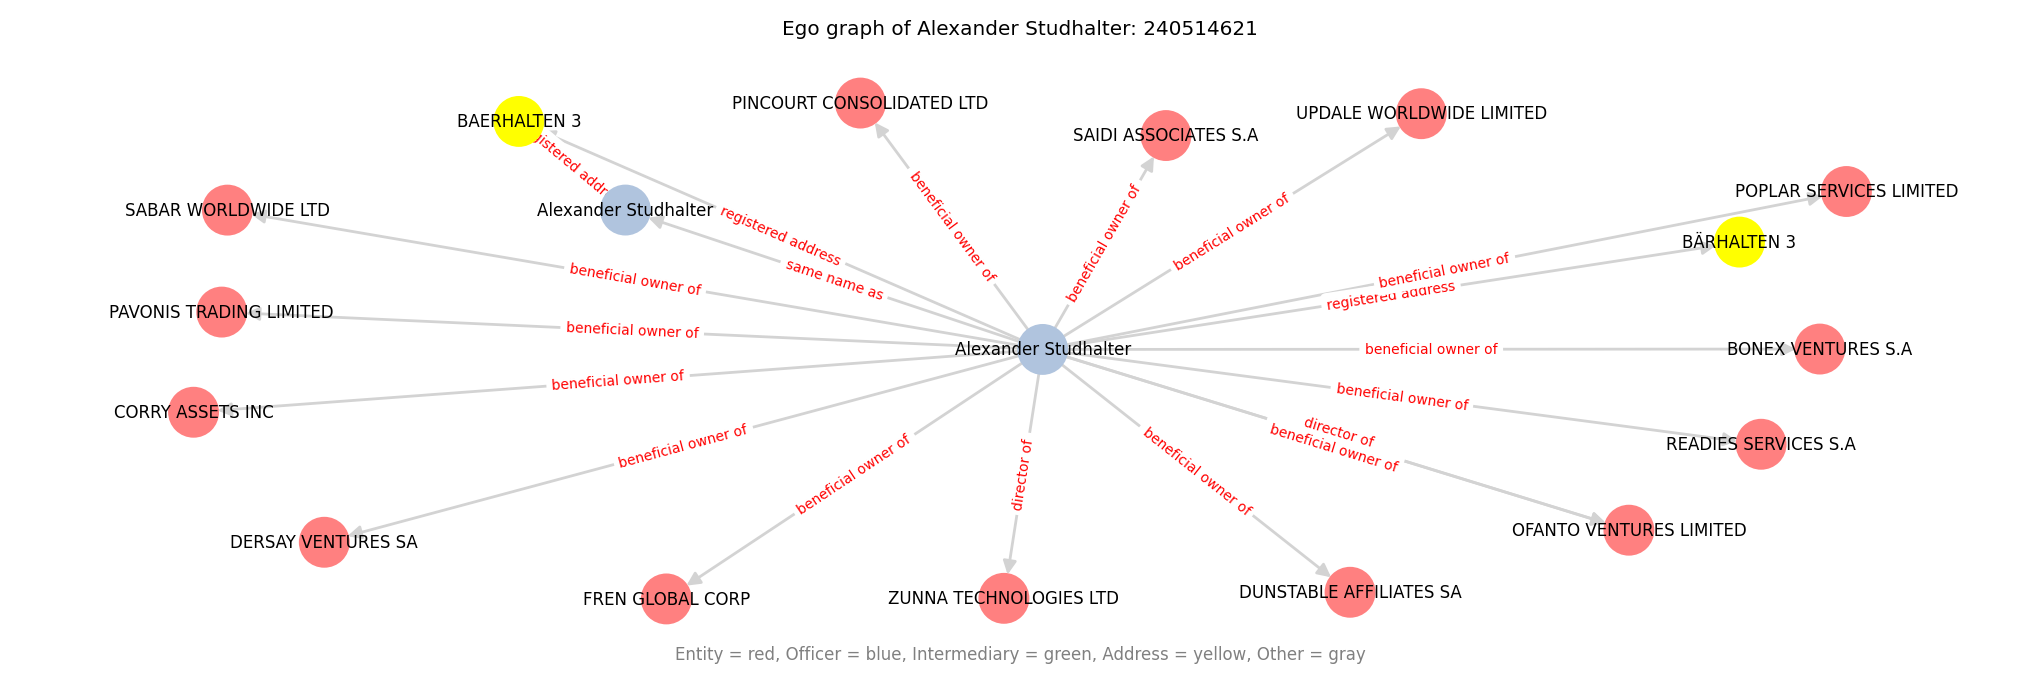

In [8]:
# Use the modified plotting function
for node, deg in list(degree.items())[:5]:
    print(f"Node: {node}, Name: {new_G.nodes[node]['name']}, Entity Out-Degree: {deg}")
    utils.plot_ego_with_labels(
        new_G, node, color_map, plot_type_circular=False
    )

Hier sehen wir bereits einen viel besseren Plot. Wegen einigen Differenzen in den Attributen, konnten nicht alle Nodes vereinigt werden, ohne starke Annahmen zu treffen. Diese Annahmen könnten jedoch falsch sein und somit die Analyse verfälschen, deshalb haben wir uns entschieden, die Nodes nicht zu vereinigen.

Jedoch können wir jetzt die Top 5 Schweizer Officers und deren Offshore Firmen sehen. Der Officer mit den meisten Offshore Firmen ist RUSLAN GORYUKHIN mit 28 Offshore Firmen. 